In [2]:
import warnings

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyvista as pv

warnings.simplefilter('ignore')

## Feature Size Relative to Domain Size

### Current Density Normalized Standard Deviation

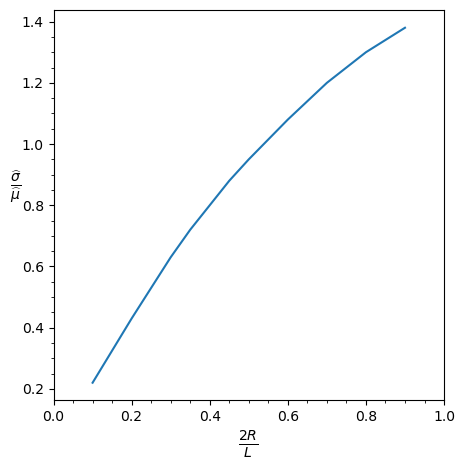

In [128]:
df = pd.read_excel('data/study_3.xlsx', sheet_name=['linear-raw'])
df = df['linear-raw']
fig, ax = plt.subplots()

for Wa in [1e-5, 1e3]:
    data = df.loc[df['Wa'] == Wa, :]
    line, = ax.plot(data['relative_radius'], data['current_std'])
    line.set_label(f'Wa = {Wa:.0e}')
ax.set_xlabel(r'$\frac{2R}{L}$', fontdict={'fontsize': 'x-large'});
ax.set_ylabel(r'$\frac{\widehat{\sigma}}{\widehat{\mu}}$', fontdict={'fontsize': 'x-large'}, rotation=0);
ax.legend()
ax.set_xlim([0, 1]);
ax.set_box_aspect(1);
ax.minorticks_on();
ax.set_title('Linear Kinetics');
plt.tight_layout();
plt.savefig('figures/relative-size-features-linear.png', dpi=1200);

#### Butler-Volmer Kinetics

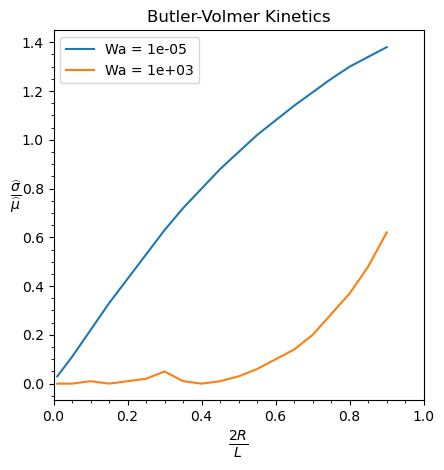

In [16]:
df = pd.read_excel('data/study_3.xlsx', sheet_name=['bv-raw'])
df = df['bv-raw']

fig, ax = plt.subplots()

for Wa in [1e-5, 1e3]:
    data = df.loc[df['Wa'] == Wa, :]
    line, = ax.plot(data['relative_radius'], data['current_std'])
    line.set_label(f'Wa = {Wa:.0e}')
ax.set_xlabel(r'$\frac{2R}{L}$', fontdict={'fontsize': 'x-large'});
ax.set_ylabel(r'$\frac{\widehat{\sigma}}{\widehat{\mu}}$', fontdict={'fontsize': 'x-large'}, rotation=0);
ax.legend()
ax.set_xlim([0, 1]);
ax.set_box_aspect(1);
ax.minorticks_on();
ax.set_title('Butler-Volmer Kinetics');
plt.tight_layout();
plt.savefig('figures/relative-size-features-bv.png', dpi=1200);

### Linear Kinetics

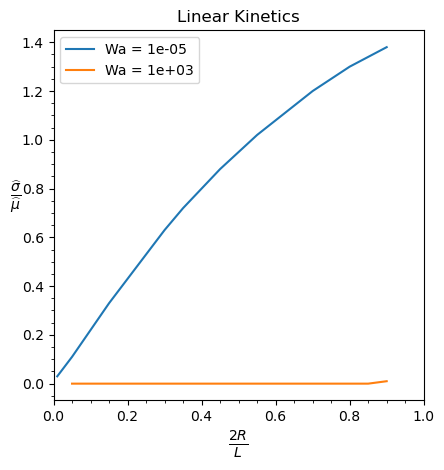

In [44]:
df = pd.read_excel('data/study_3.xlsx', sheet_name=['linear-raw'])
df = df['linear-raw']

fig, ax = plt.subplots()

for Wa in [1e-5, 1e3]:
    data = df.loc[df['Wa'] == Wa, :]
    line, = ax.plot(data['relative_radius'], data['current_std'])
    line.set_label(f'Wa = {Wa:.0e}')
ax.set_xlabel(r'$\frac{2R}{L}$', fontdict={'fontsize': 'x-large'});
ax.set_ylabel(r'$\frac{\widehat{\sigma}}{\widehat{\mu}}$', fontdict={'fontsize': 'x-large'}, rotation=0);
ax.legend()
ax.set_xlim([0, 1]);
ax.set_box_aspect(1);
ax.minorticks_on();
ax.set_title('Linear Kinetics');
plt.tight_layout();
plt.savefig('figures/relative-size-features-linear.png', dpi=1200);

### Current Density vs Angle

In [18]:
L = 1e-3

def get_angle(coord, radius):
    
    r = np.linalg.norm(coord[:-1] - 0.5 * L, 2)

    if not np.isclose(r/radius, 1):
        return np.nan
    
    if coord[1] < 0.5 * L:
        return np.nan

    adjacent = 0.5 * L - coord[0]

    return np.arccos(adjacent / radius)

In [19]:
def get_circle_coords(linemesh):
    coords = linemesh['/data0']
    lines = linemesh['/data1']
    markers = linemesh['/data2']
    line_coords = np.where(np.isclose(markers, 2))

    return np.unique(lines[line_coords])

In [40]:
def get_angular_values(rscale, Wa=0.00001, kinetics='bv'):
    R = rscale * 0.5 * L
    linemesh = h5py.File(f'mesh/study_3_{kinetics}/{Wa}/{rscale}/line.h5', 'r')
    data = h5py.File(f'mesh/study_3_{kinetics}/{Wa}/{rscale}/current.h5', 'r')
    coords = data['/Mesh/Grid/geometry']

    values = data['/Function/f/0']

    angles = []
    angles_values = []
    coords2 = get_circle_coords(linemesh)

    for i in range(coords.shape[0]):
        angle = get_angle(coords[i, :], radius=R)
        if np.isnan(angle):
            continue

        angles.append(angle)
        n = (np.array([0.5 * L, 0.5 * L, 0]) - coords[i, :]) / R
        angles_values.append(np.dot(values[i, :], n))
    
    angles = np.array(angles).reshape(-1, 1)
    angles_values = np.array(angles_values).reshape(-1, 1)
    arr = np.hstack((angles, angles_values))
    arr = np.take_along_axis(arr, np.argsort(arr, axis=0), axis=0)

    return arr

Processing for relative scale 0.01
Processing for relative scale 0.1
Processing for relative scale 0.3
Processing for relative scale 0.5
Processing for relative scale 0.7
[Errno 2] Unable to open file (unable to open file: name = 'mesh/study_3_bv/0.00001/0.7/current.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Processing for relative scale 0.9
Processing for relative scale 0.01
Processing for relative scale 0.1
Processing for relative scale 0.3
Processing for relative scale 0.5
Processing for relative scale 0.7
Processing for relative scale 0.9


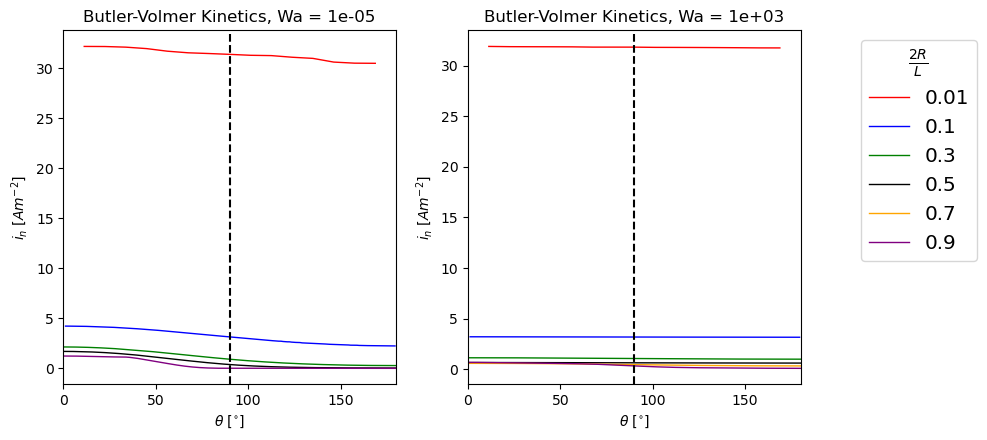

In [41]:
Wa_nums = ['0.00001', '1000']
kinetics = 'bv'
colors =  ['red', 'blue', 'green', 'black', 'orange', 'purple', 'grey', 'yellow', 'violet']
fig, axes = plt.subplots(1, 2, figsize=(10, 4.5))

for j, Wa in enumerate(Wa_nums):
    ax = axes[j]
    for i, rscale in enumerate([0.01, 0.1, 0.3, 0.5, 0.7, 0.9]):
        print(f"Processing for relative scale {rscale}")
        try:
            arr = get_angular_values(rscale, Wa=Wa, kinetics=kinetics)
            line, = ax.plot(180 - (180/np.pi) * arr[:, 0], arr[:, 1], linewidth=1, color=colors[i]);
            line.set_label(f"{rscale}");
        except Exception as e:
            print(e)
            continue
    ax.axvline(x=90, color='black', ls='--');
    ax.set_xlabel(r'$\theta$ [$^{\circ}$]');
    ax.set_ylabel('$i_n$ [$Am^{-2}$]');
    ax.set_xlim([0, 180]);
    ax.set_title(f'Butler-Volmer Kinetics, Wa = {float(Wa):.0e}');
axes[-1].legend(title=r'$\frac{2R}{L}$', bbox_to_anchor=(1.15, 1.0), title_fontsize='x-large', fontsize='x-large', loc='upper left');
plt.tight_layout();
plt.savefig(f'figures/relative-size-features-angular-{kinetics}-a.png', dpi=1200);

Processing for relative scale 0.1
Processing for relative scale 0.3
Processing for relative scale 0.5
Processing for relative scale 0.7
[Errno 2] Unable to open file (unable to open file: name = 'mesh/study_3_bv/0.00001/0.7/current.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Processing for relative scale 0.9
Processing for relative scale 0.1
Processing for relative scale 0.3
Processing for relative scale 0.5
Processing for relative scale 0.7
Processing for relative scale 0.9


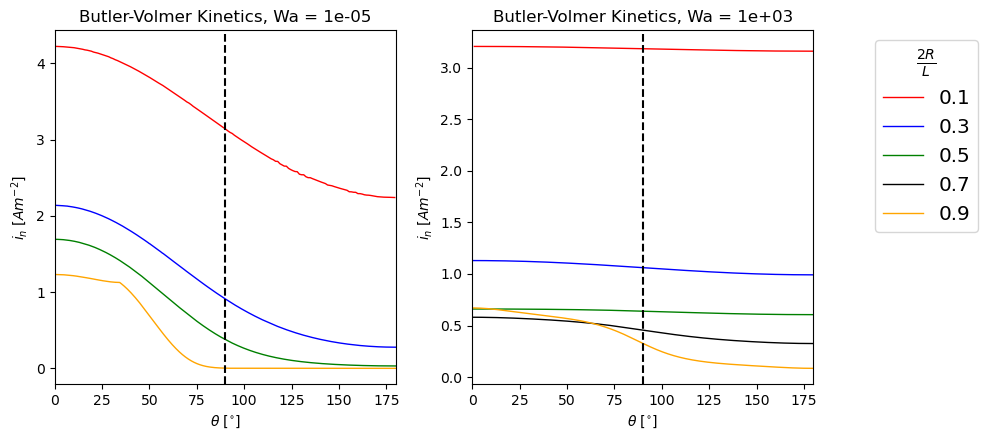

In [42]:
Wa_nums = ['0.00001', '1000']

colors =  ['red', 'blue', 'green', 'black', 'orange', 'purple', 'grey', 'yellow', 'violet']
fig, axes = plt.subplots(1, 2, figsize=(10, 4.5))

for j, Wa in enumerate(Wa_nums):
    ax = axes[j]
    for i, rscale in enumerate([0.1, 0.3, 0.5, 0.7, 0.9]):
        print(f"Processing for relative scale {rscale}")
        try:
            arr = get_angular_values(rscale, Wa=Wa, kinetics=kinetics)
            line, = ax.plot(180 - (180/np.pi) * arr[:, 0], arr[:, 1], linewidth=1, color=colors[i]);
            line.set_label(f"{rscale}");
        except Exception as e:
            print(e)
            continue
    ax.axvline(x=90, color='black', ls='--');
    ax.set_xlabel(r'$\theta$ [$^{\circ}$]');
    ax.set_ylabel('$i_n$ [$Am^{-2}$]');
    ax.set_xlim([0, 180]);
    ax.set_title(f'Butler-Volmer Kinetics, Wa = {float(Wa):.0e}');
axes[-1].legend(title=r'$\frac{2R}{L}$', bbox_to_anchor=(1.15, 1.0), title_fontsize='x-large', fontsize='x-large', loc='upper left');
plt.tight_layout();
plt.savefig(f'figures/relative-size-features-angular-{kinetics}-b.png', dpi=1200);

### Linear Kinetics

Processing for relative scale 0.01
Processing for relative scale 0.1
Unable to open file (file signature not found)
Processing for relative scale 0.3
Processing for relative scale 0.5
Processing for relative scale 0.7
Processing for relative scale 0.9
Processing for relative scale 0.01
Processing for relative scale 0.1
Processing for relative scale 0.3
Processing for relative scale 0.5
Processing for relative scale 0.7
Unable to open file (file signature not found)
Processing for relative scale 0.9


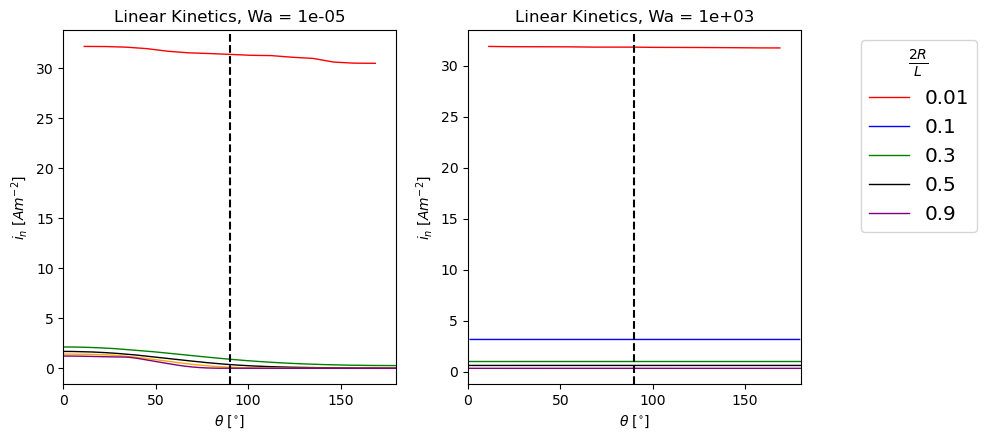

In [45]:
Wa_nums = ['0.00001', '1000']
kinetics = 'linear'
colors =  ['red', 'blue', 'green', 'black', 'orange', 'purple', 'grey', 'yellow', 'violet']
fig, axes = plt.subplots(1, 2, figsize=(10, 4.5))

for j, Wa in enumerate(Wa_nums):
    ax = axes[j]
    for i, rscale in enumerate([0.01, 0.1, 0.3, 0.5, 0.7, 0.9]):
        print(f"Processing for relative scale {rscale}")
        try:
            arr = get_angular_values(rscale, Wa=Wa, kinetics=kinetics)
            line, = ax.plot(180 - (180/np.pi) * arr[:, 0], arr[:, 1], linewidth=1, color=colors[i]);
            line.set_label(f"{rscale}");
        except Exception as e:
            print(e)
            continue
    ax.axvline(x=90, color='black', ls='--');
    ax.set_xlabel(r'$\theta$ [$^{\circ}$]');
    ax.set_ylabel('$i_n$ [$Am^{-2}$]');
    ax.set_xlim([0, 180]);
    ax.set_title(f'Linear Kinetics, Wa = {float(Wa):.0e}');
axes[-1].legend(title=r'$\frac{2R}{L}$', bbox_to_anchor=(1.15, 1.0), title_fontsize='x-large', fontsize='x-large', loc='upper left');
plt.tight_layout();
plt.savefig(f'figures/relative-size-features-angular-{kinetics}-a.png', dpi=1200);

Processing for relative scale 0.1
Unable to open file (file signature not found)
Processing for relative scale 0.3
Processing for relative scale 0.5
Processing for relative scale 0.7
Processing for relative scale 0.9
Processing for relative scale 0.1
Processing for relative scale 0.3
Processing for relative scale 0.5
Processing for relative scale 0.7
Unable to open file (file signature not found)
Processing for relative scale 0.9


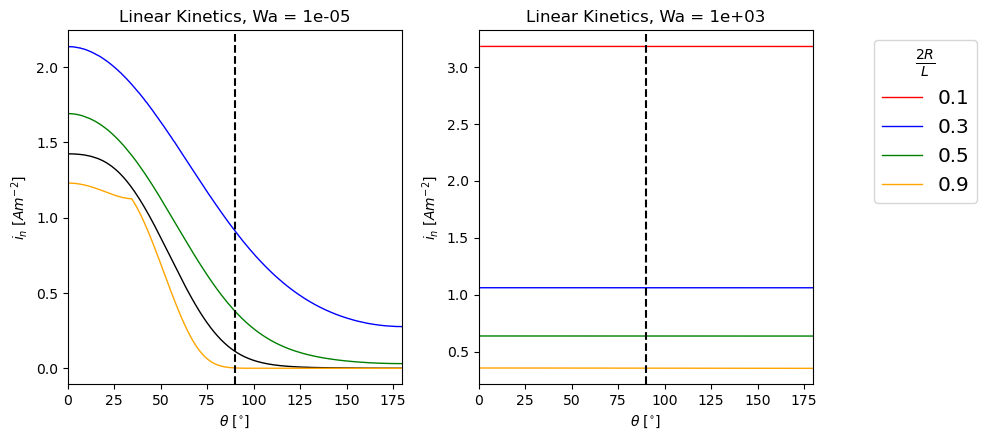

In [46]:
Wa_nums = ['0.00001', '1000']
kinetics = 'linear'
colors =  ['red', 'blue', 'green', 'black', 'orange', 'purple', 'grey', 'yellow', 'violet']
fig, axes = plt.subplots(1, 2, figsize=(10, 4.5))

for j, Wa in enumerate(Wa_nums):
    ax = axes[j]
    for i, rscale in enumerate([0.1, 0.3, 0.5, 0.7, 0.9]):
        print(f"Processing for relative scale {rscale}")
        try:
            arr = get_angular_values(rscale, Wa=Wa, kinetics=kinetics)
            line, = ax.plot(180 - (180/np.pi) * arr[:, 0], arr[:, 1], linewidth=1, color=colors[i]);
            line.set_label(f"{rscale}");
        except Exception as e:
            print(e)
            continue
    ax.axvline(x=90, color='black', ls='--');
    ax.set_xlabel(r'$\theta$ [$^{\circ}$]');
    ax.set_ylabel('$i_n$ [$Am^{-2}$]');
    ax.set_xlim([0, 180]);
    ax.set_title(f'Linear Kinetics, Wa = {float(Wa):.0e}');
axes[-1].legend(title=r'$\frac{2R}{L}$', bbox_to_anchor=(1.15, 1.0), title_fontsize='x-large', fontsize='x-large', loc='upper left');
plt.tight_layout();
plt.savefig(f'figures/relative-size-features-angular-{kinetics}-b.png', dpi=1200);

### Sample Current Flow Diagrams

In [39]:
reader = pv.XdmfReader("mesh/study_3/0.3/current.xdmf")
_, current = reader.read()
current.set_active_scalars('f')
current.plot(cmap="turbo")

Widget(value="<iframe src='http://localhost:38229/index.html?ui=P_0x7fbb58eafca0_17&reconnect=auto' style='wid…

## Apparent Effective Conductivity

In [71]:
# df = pd.read_excel('data/study_4.xlsx', sheet_name=['L0', 'L1', 'L2'])

# fig, ax = plt.subplots()

# labels = {'L0': '$L=L_0$', 'L1': '$L = 0.25 L_0$', 'L2': '$L=4L_0$'}
# for k, v in labels.items():
#     line, = ax.plot(df[k]['area_fraction'], df[k]['effective_conductivity'])
#     line.set_label(v)
# ax.legend();
# ax.set_xlabel(r'$\frac{A}{A_0}$', fontdict={'fontsize': 'x-large'});
# ax.set_ylabel(r'$\frac{\kappa_{eff}}{\kappa_{bulk}}$', fontdict={'fontsize': 'x-large'});
# ax.set_xlim([0, 1]);
# ax.set_ylim([0, 1]);
# ax.set_box_aspect(1);
# plt.tight_layout();
# plt.savefig('figures/effective-conductivity-partial-area.png', dpi=1200);

ValueError: Worksheet named 'L0' not found

## Contact Area Distributed

In [ ]:
# df = pd.read_csv('data/contact-area-distributed.csv')
# fig, ax = plt.subplots()
# ax.semilogx(df['n_pieces'], df['resistance [Ohm]'])
# ax.set_xlabel('$n_{pieces}$', fontdict={'size': 'x-large'});
# ax.set_ylabel('Resistance $[\Omega]$', fontdict={'size': 'x-large'});
# ax.set_title('$\kappa$ = 1 $Sm^{-1}$')
# plt.tight_layout();
# plt.savefig('figures/contact-area-distributed-semilog.png', dpi=1200);

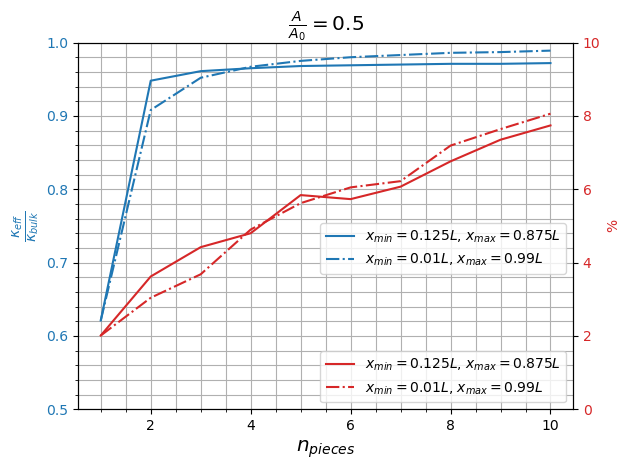

In [70]:
df = pd.read_excel('data/contact-area-distributed.xlsx', sheet_name=['data2', 'data3'])
fig, ax = plt.subplots()
ax2 = ax.twinx()
colors = ['tab:blue', 'tab:red']
labels = ['$x_{min} = 0.125 L$, $x_{max} = 0.875 L$', '$x_{min} = 0.01 L$, $x_{max} = 0.99 L$']
types = ['-', '-.']
for i, data_name in enumerate(['data2', 'data3']):
    line1, = ax.plot(df[data_name]['n_pieces'], df[data_name]['effective_conductivity'], types[i], color=colors[0])
    line1.set_label(labels[i])
    line2, = ax2.plot(df[data_name]['n_pieces'], 100 * df[data_name]['converge_error'], types[i], color=colors[1]);
    line2.set_label(labels[i])
ax.set_xlabel(r'$n_{pieces}$', fontdict={'fontsize': 'x-large'});
ax.set_ylabel(r'$\frac{\kappa_{eff}}{\kappa_{bulk}}$', fontdict={'fontsize': 'x-large'}, color=colors[0]);
ax.set_title(r'$\frac{A}{A_0} = 0.5$', fontdict={'fontsize': 'x-large'})
ax2.set_ylabel('%', color=colors[1]);
ax.tick_params(axis='y', labelcolor=colors[0])
ax2.tick_params(axis='y', labelcolor=colors[1])
ax.set_ylim([0.5, 1]);
ax2.set_ylim([0, 10]);
ax.legend();
ax.legend(bbox_to_anchor=(1.0, 0.35), loc='lower right');
ax2.legend(bbox_to_anchor=(1.0, 0), loc='lower right');
ax.grid(True, which='both');
ax.minorticks_on()
plt.tight_layout();
plt.savefig('figures/contact-area-distributed-conductivity.png', dpi=1200);

# Contact Area Fraction and Aspect Ratio

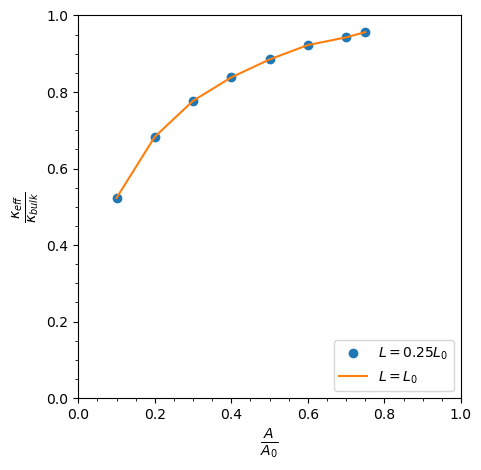

In [35]:
df = pd.read_excel('data/study_4.xlsx', sheet_name=['data1', 'data2'])
fig, ax = plt.subplots()
ax.plot(df['data1']['area_fraction'], df['data1']['effective_conductivity'], 'o', label='$L=0.25L_0$')
ax.plot(df['data2']['area_fraction'], df['data2']['effective_conductivity'], label='$L=L_0$')
ax.legend(loc='lower right')
ax.set_ylabel(r'$\frac{\kappa_{eff}}{\kappa_{bulk}}$', fontdict={'fontsize': 'x-large'});
ax.set_xlabel(r'$\frac{A}{A_0}$', fontdict={'fontsize': 'x-large'})
ax.set_xlim([0, 1]);
ax.set_ylim([0, 1]);
ax.minorticks_on();
ax.set_aspect(1);
plt.tight_layout();
plt.savefig('figures/contact-area-fraction-conductivity.png', dpi=1200);

In [11]:
df['data1'].head()

,area_fraction,effective_conductivity
0,0.099998,0.52333
1,0.200000,0.68311
2,0.300000,0.77708
3,0.400000,0.83840
4,0.500000,0.88527


## Study 5: Current Distribution with Defect

In [5]:
df = pd.read_excel('data/study_5.xlsx', sheet_name=['data'])

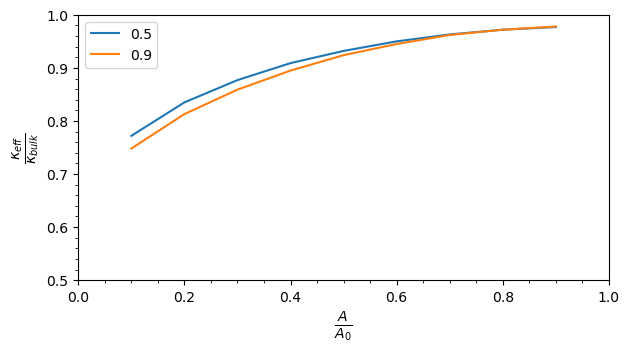

In [18]:
fix, ax = plt.subplots()
for pos in [0.5, 0.9]:
    data = df['data'].loc[df['data']['pos'] == pos, :]
    ax.plot(data['eps'], data['effective_conductivity_ratio'], label=pos)
#     line.set_label(f'{pos}')
ax.set_ylabel(r'$\frac{\kappa_{eff}}{\kappa_{bulk}}$', fontdict={'fontsize': 'x-large'});
ax.set_xlabel(r'$\frac{A}{A_0}$', fontdict={'fontsize': 'x-large'})
ax.legend()
ax.set_xlim([0, 1]);
ax.set_ylim([0.5, 1]);
ax.minorticks_on();
ax.set_aspect(1);
plt.tight_layout();
plt.savefig('figures/contact-area-fraction-defect-conductivity.png', dpi=1200);